In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 

Path of the data that will be used for the training.

The training will be a two-step process:

- Fine tuning the LM on the target corpus (with the labelled data we want to classify + unlabelled data of the same distribution, if available). PATH_LM is the directory containing the train.csv file for fine tuning.
- Using the fine tuned LM to do a classification task. PATH_CS is the directory containing the train.csv file for classification.

In [2]:
PATH_LM = Path('data/class/lm/')
PATH_CS = Path('data/class/')

The tokenizer will be used to transform the text. As we are working on french LM, it is very important to use a tokenizer supporting the french language. Fastai uses Spacy.

In [66]:
tokenizer = Tokenizer(lang='fr', n_cpus=5)
data_lm = TextLMDataBunch.from_csv(PATH_LM, tokenizer=tokenizer, bs=32, csv_name='train.csv')

In [4]:
data_lm.save('data_lm')

In [3]:
data_lm = TextLMDataBunch.load(PATH_LM, 'data_lm', bs=64)

# Fine tuning LM

To use the pretrained LM, we have to load two files:

- Weights of the pretrained LM (weights_pretrained)
- Mapping of the vocabulary of the pretrained model (itos_pretrained)

This will enable the learner to load the weights of the pretrained model and to map the vocabulary of the new data with the data used for pretraining. For vocab which appear in the corpus used for pretraining, the same embeddings weights will be used. For new vocab, the average of embeddings weights will be used

In [4]:
weights_pretrained = 'wref30k'
itos_pretrained = 'itosref30k'
pretained_data = (weights_pretrained, itos_pretrained)

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretained_data, drop_mult=0)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


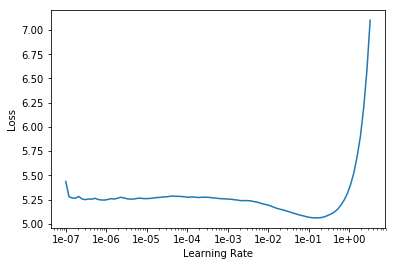

In [11]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

First step, we do a learning cycle on last layers, then we unfreeze to do fine tuning on all layers, with a lower LR.

In [12]:
learn.fit_one_cycle(1, 1e-2)

Total time: 02:35
epoch  train_loss  valid_loss  accuracy
1      3.996655    3.963292    0.268895  (02:35)



In [13]:
learn.save('head_pretrained')

In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

Total time: 06:04
epoch  train_loss  valid_loss  accuracy
1      3.652122    3.779533    0.291331  (03:03)
2      3.394582    3.720815    0.301165  (03:01)



In [15]:
learn.save('lm_fine_tuned')

In [16]:
learn.save_encoder('ft_enc')

# Classification task

Now, we have a LM fine-tuned to our target corpus.
The next step is to add layers on top of our LM to do a classification task. 
With fastai, it is very easy at it's done automatically.

In [67]:
data_clas = TextClasDataBunch.from_csv(PATH_CS, vocab=data_lm.train_ds.vocab, bs=64, csv_name='newtrain.csv', tokenizer=tokenizer)

In [85]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


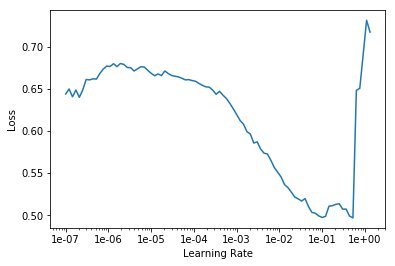

In [84]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

The training will start on the last layers and we will progressively unfreeze the previous layers. 

In [87]:
learn.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(34639, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(34639, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.12)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
      (6): Linear(in_features=50, out_features=2, bias=

In [69]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

Total time: 00:36
epoch  train_loss  valid_loss  accuracy
1      0.351244    0.243372    0.891209  (00:19)
2      0.309314    0.212722    0.911496  (00:17)



In [70]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 00:22
epoch  train_loss  valid_loss  accuracy
1      0.255121    0.179522    0.922434  (00:22)



In [71]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 00:34
epoch  train_loss  valid_loss  accuracy
1      0.201515    0.162637    0.928998  (00:34)



In [72]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 01:23
epoch  train_loss  valid_loss  accuracy
1      0.193950    0.159179    0.929793  (00:41)
2      0.182214    0.157030    0.931981  (00:42)



In [74]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 01:27
epoch  train_loss  valid_loss  accuracy
1      0.192346    0.158431    0.930986  (00:43)
2      0.149318    0.155046    0.934964  (00:44)



In [75]:
learn.save('class-0.9349')